# Train xView2 with FastAIv2

The currenty first place model of xView2 uses a total of eight models (one each of 34, 50, 92, and 154 for both cls and loc). The goal is to create a single model for each of loc and cls, potentially a single model for both. Additionally, we would like to use an architecture that can support multiple sizes to support better accuracy on accelerated machines or reduced accuracy capable of running on an edge device.

In [6]:
from fastai.vision.all import *
from fastai.optimizer import ranger
from pathlib import Path
from PIL import Image

In [7]:
TRAIN_PATH = Path("data/train")
DEVICE = "cuda:1"

In [34]:
# TODO: Setup for using just post imagery. Need to concat pre/post as input
fnames = [f for f in get_image_files(TRAIN_PATH/"images") if "post" in f.name]
lbl_names = [f for f in get_image_files(TRAIN_PATH/"targets") if "post" in f.name]

def get_x(path):
    return [f for f in get_image_files(path) if "post" in f.name]

def get_y(path):
    return [f for f in get_image_files(path) if "post" in f.name]

<Axes: >

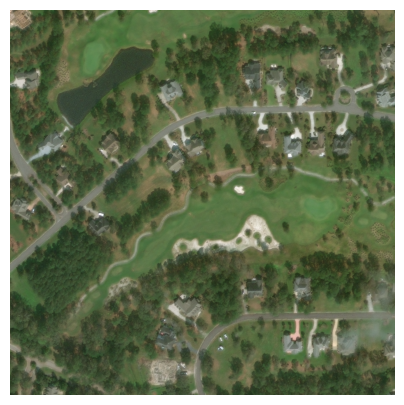

In [35]:
img_test = fnames[5]
PILImage.create(img_test).show()

In [36]:
# fn to get corresponding target image
get_label = lambda x: TRAIN_PATH/'targets'/f'{x.stem}_target.png'

<Axes: >

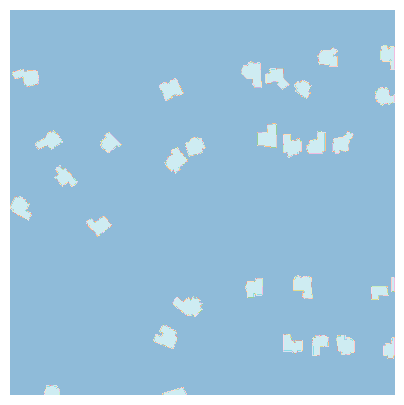

In [37]:
msk = PILMask.create(get_label(img_test))
msk.show()

In [14]:
sz = msk.shape; sz

(1024, 1024)

In [15]:
half = tuple(int(x/2) for x in sz); half

(512, 512)

In [39]:
db = DataBlock(blocks=(ImageBlock, MaskBlock),
               get_items=get_x,
            #    get_x=lambda x: print(x.name),
               get_y=get_label,
               splitter=RandomSplitter(),
               batch_tfms=[*aug_transforms(size=half)])

# dsets = db.datasets(fnames)

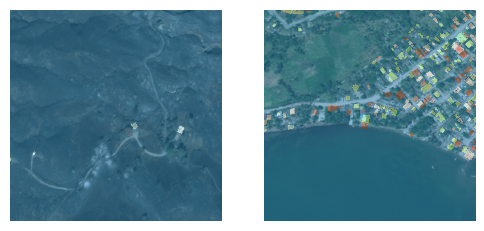

In [41]:
dls = db.dataloaders(TRAIN_PATH/"images", bs=2)

# dls = SegmentationDataLoaders()

# dls.device = DEVICE

dls.show_batch(max_n=4)

In [42]:
opt = ranger
f1score = F1Score()
learn = unet_learner(dls, resnet34, metrics=f1score, self_attention=True, opt_func=opt, n_out=5)
learn.summary()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:21<00:00, 4.07MB/s]

: 

SuggestedLRs(valley=0.0002290867705596611)

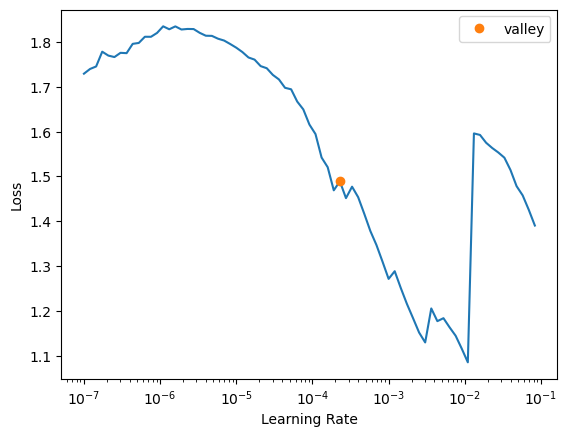

In [25]:
learn.lr_find()

In [26]:
lr = 2e-4

In [28]:
learn.fit_flat_cos(10, slice(lr))

epoch,train_loss,valid_loss,f1_score,time


AssertionError: Exception occured in `Recorder` when calling event `after_batch`:
	==:
5120
524288

In [23]:
len()

2